In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/7981.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/6234.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/1269.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/3863.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/6241.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/10304.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/623.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/2193.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/11925.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/3750.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/11378.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/2008.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/10730.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Do

# Preparing dataset

In [2]:
data_dir = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"

In [3]:
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, random_split, Subset
import torch

def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + torch.randn_like(tensor) * std

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.03),

    transforms.RandomApply([
        transforms.RandomRotation(10),
    ], p=0.3),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.01, 1.0))
    ], p=0.45),
    
    transforms.ToTensor(),
    
    transforms.RandomApply([
        transforms.Lambda(lambda x: add_gaussian_noise(x, std=0.03))
    ], p=0.3),
    
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

raw_dataset = datasets.ImageFolder(data_dir)

total = len(raw_dataset)
train_len = int(0.8 * total)
val_len = int(0.1 * total)
test_len = total - train_len - val_len

g = torch.Generator().manual_seed(42)

train_idx, val_idx, test_idx = random_split(
    raw_dataset, 
    [train_len, val_len, test_len],
    generator=g
)

train_ds = Subset(
    datasets.ImageFolder(data_dir, transform=train_transform),
    train_idx.indices
)

val_ds = Subset(
    datasets.ImageFolder(data_dir, transform=test_transform),
    val_idx.indices
)

test_ds = Subset(
    datasets.ImageFolder(data_dir, transform=test_transform),
    test_idx.indices
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

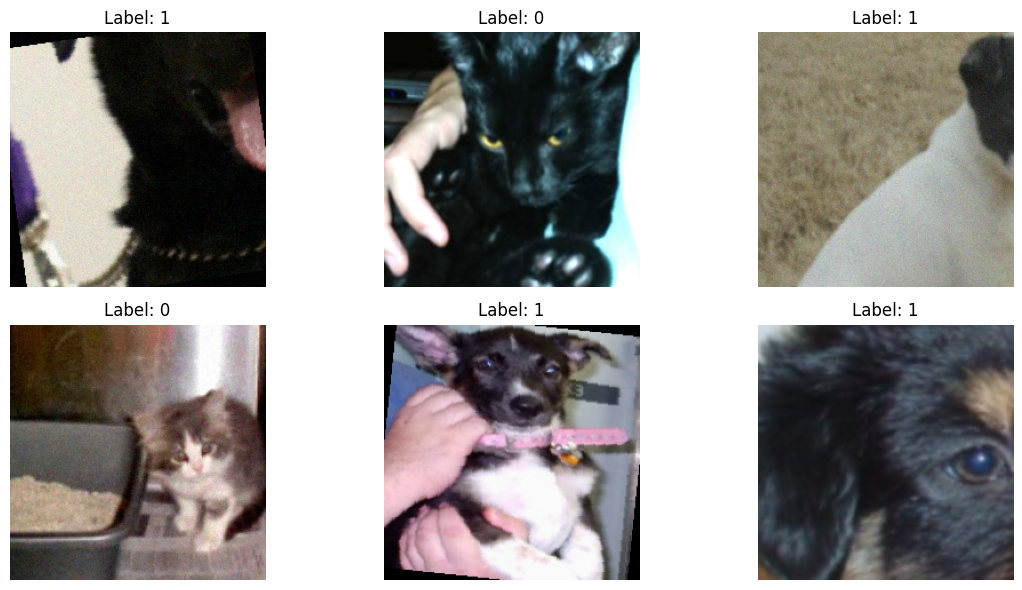

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denorm(img):
    img = img * 0.5 + 0.5
    img = img.clamp(0, 1)
    return img

def show_augmented_samples(dataset, num_samples=6):
    plt.figure(figsize=(12, 6))
    
    for i in range(num_samples):
        idx = torch.randint(0, len(dataset), (1,)).item()
        img, label = dataset[idx]

        img = denorm(img)

        img_np = img.permute(1, 2, 0).numpy()

        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

show_augmented_samples(train_ds, num_samples=6)


# Training models

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import json
from datetime import datetime
import os
from tqdm import tqdm
import time
import csv

def calculate_metrics(predictions, labels):
    pred_np = predictions.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    precision = precision_score(labels_np, pred_np, average='binary', zero_division=0)
    recall = recall_score(labels_np, pred_np, average='binary', zero_division=0)
    f1 = f1_score(labels_np, pred_np, average='binary', zero_division=0)
    return precision, recall, f1

def save_csv_log(csv_file, header, row):
    file_exists = os.path.isfile(csv_file)
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(header)
        writer.writerow(row)

def train_model(model, train_loader, val_loader, device="cuda",
               epochs=50, lr=1e-4, log_dir="training_logs",
               early_stop_metric="val_loss", patience=5,
               save_best_model=True, csv_log_name="training_log.csv", model_name="best_model.pth"):

    os.makedirs(log_dir, exist_ok=True)
    csv_log_file = os.path.join(log_dir, csv_log_name)
    best_model_path = os.path.join(log_dir, model_name)
    best_model_path_state_dict = os.path.join(log_dir, "state_dict_" + model_name)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_metric_value = float("inf") if "loss" in early_stop_metric else -float("inf")
    counter = 0

    header = ['epoch', 'loss', 'accuracy', 'precision', 'recall', 'f1',
          'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'epoch_time_sec']

    device = device if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    for epoch in range(epochs):
        # print(f"Starting epoch {epoch+1}/{epochs}...")
        start_time = time.time()
        model.train()
        total, correct, loss_sum = 0, 0, 0
        all_train_preds, all_train_labels = [], []

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} train"):
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            pred = torch.sigmoid(outputs) > 0.5
            pred = pred.long()
            labels = labels.long()

            all_train_preds.append(pred)
            all_train_labels.append(labels)
        
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        train_loss = loss_sum / len(train_loader)
        train_acc = correct / total
        all_train_preds = torch.cat(all_train_preds).view(-1)
        all_train_labels = torch.cat(all_train_labels).view(-1)
        train_precision, train_recall, train_f1 = calculate_metrics(all_train_preds, all_train_labels)
    
        model.eval()
        val_total, val_correct, val_loss_sum = 0, 0, 0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                
                val_loss_sum += loss.item()
                pred = torch.sigmoid(outputs) > 0.5
                pred = pred.long()
                labels = labels.long()
        
                all_val_preds.append(pred)
                all_val_labels.append(labels)
                
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()
    
        val_loss = val_loss_sum / len(val_loader)
        all_val_preds = torch.cat(all_val_preds).view(-1)
        all_val_labels = torch.cat(all_val_labels).view(-1)
    
        val_acc = val_correct / val_total
        val_precision, val_recall, val_f1 = calculate_metrics(all_val_preds, all_val_labels)

        epoch_duration = time.time() - start_time

        row = [epoch+1, train_loss, train_acc, train_precision, train_recall, train_f1,
           val_loss, val_acc, val_precision, val_recall, val_f1, epoch_duration]

        save_csv_log(csv_log_file, header, row)

        # Drukowanie wyników
        print(f"Epoch {epoch+1}/{epochs} finished in {epoch_duration:.2f} seconds ({epoch_duration/60} minutes)")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1: {train_f1:.3f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.3f}, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1: {val_f1:.3f}")
        print("-" * 80)
    
        current_metric = val_loss if early_stop_metric == "val_loss" else locals()[early_stop_metric]
        if ("loss" in early_stop_metric and current_metric < best_metric_value) or \
           ("loss" not in early_stop_metric and current_metric > best_metric_value):
            best_metric_value = current_metric
            counter = 0
            if save_best_model:
                torch.save(model, best_model_path)
                torch.save(model.state_dict(), best_model_path_state_dict)
                print(f"Saved best model at epoch {epoch+1}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"\nTraining completed! CSV log: {csv_log_file}")
    if save_best_model:
        print(f"Best model saved at: {best_model_path}")

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
    
        self.features = nn.Sequential(
            block(3, 32),
            block(32, 64),
            block(64, 128),
            block(128, 256),
            block(256, 512),
        )
    
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
train_model(CNN(), train_loader, val_loader, log_dir="CNN_model", early_stop_metric="val_acc", epochs=20)

Epoch 1 train:  32%|███▏      | 197/625 [02:11<04:44,  1.51it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1 train: 100%|██████████| 625/625 [07:08<00:00,  1.46it/s]


Epoch 1/20 finished in 455.75 seconds (7.595795981089274 minutes)
Train - Loss: 0.6484, Acc: 0.624, Precision: 0.640, Recall: 0.571, F1: 0.603
Val   - Loss: 0.6629, Acc: 0.593, Precision: 0.556, Recall: 0.944, F1: 0.700
--------------------------------------------------------------------------------
Saved best model at epoch 1


Epoch 2 train:  36%|███▌      | 222/625 [01:50<03:15,  2.06it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 2 train: 100%|██████████| 625/625 [05:13<00:00,  1.99it/s]


Epoch 2/20 finished in 326.16 seconds (5.435984710852305 minutes)
Train - Loss: 0.6113, Acc: 0.670, Precision: 0.692, Recall: 0.612, F1: 0.650
Val   - Loss: 0.5651, Acc: 0.718, Precision: 0.694, Recall: 0.786, F1: 0.737
--------------------------------------------------------------------------------
Saved best model at epoch 2


Epoch 3 train:  90%|████████▉ | 561/625 [04:37<00:31,  2.02it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 3 train: 100%|██████████| 625/625 [05:09<00:00,  2.02it/s]


Epoch 3/20 finished in 321.17 seconds (5.35279122988383 minutes)
Train - Loss: 0.5833, Acc: 0.696, Precision: 0.716, Recall: 0.652, F1: 0.682
Val   - Loss: 0.5248, Acc: 0.746, Precision: 0.738, Recall: 0.766, F1: 0.752
--------------------------------------------------------------------------------
Saved best model at epoch 3


Epoch 4 train:  26%|██▌       | 164/625 [01:20<03:43,  2.06it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 4 train: 100%|██████████| 625/625 [05:05<00:00,  2.05it/s]


Epoch 4/20 finished in 317.04 seconds (5.284042890866598 minutes)
Train - Loss: 0.5451, Acc: 0.729, Precision: 0.746, Recall: 0.693, F1: 0.719
Val   - Loss: 0.5748, Acc: 0.705, Precision: 0.641, Recall: 0.939, F1: 0.762
--------------------------------------------------------------------------------


Epoch 5 train:  24%|██▎       | 148/625 [01:11<03:56,  2.01it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 5 train: 100%|██████████| 625/625 [05:08<00:00,  2.02it/s]


Epoch 5/20 finished in 321.20 seconds (5.353294006983439 minutes)
Train - Loss: 0.4922, Acc: 0.763, Precision: 0.783, Recall: 0.727, F1: 0.754
Val   - Loss: 0.4766, Acc: 0.784, Precision: 0.745, Recall: 0.865, F1: 0.801
--------------------------------------------------------------------------------
Saved best model at epoch 5


Epoch 6 train:  34%|███▎      | 210/625 [01:43<03:20,  2.07it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 6 train: 100%|██████████| 625/625 [05:09<00:00,  2.02it/s]


Epoch 6/20 finished in 321.10 seconds (5.351713796456655 minutes)
Train - Loss: 0.4379, Acc: 0.797, Precision: 0.813, Recall: 0.772, F1: 0.792
Val   - Loss: 0.4071, Acc: 0.818, Precision: 0.907, Recall: 0.711, F1: 0.797
--------------------------------------------------------------------------------
Saved best model at epoch 6


Epoch 7 train:  58%|█████▊    | 364/625 [02:55<02:10,  2.00it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 7 train: 100%|██████████| 625/625 [05:03<00:00,  2.06it/s]


Epoch 7/20 finished in 315.89 seconds (5.264751768112182 minutes)
Train - Loss: 0.3916, Acc: 0.819, Precision: 0.835, Recall: 0.796, F1: 0.815
Val   - Loss: 0.4351, Acc: 0.820, Precision: 0.754, Recall: 0.953, F1: 0.842
--------------------------------------------------------------------------------
Saved best model at epoch 7


Epoch 8 train:  39%|███▊      | 242/625 [01:55<02:55,  2.18it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 8 train: 100%|██████████| 625/625 [05:02<00:00,  2.07it/s]


Epoch 8/20 finished in 314.35 seconds (5.239192835489908 minutes)
Train - Loss: 0.3663, Acc: 0.832, Precision: 0.845, Recall: 0.813, F1: 0.829
Val   - Loss: 0.2816, Acc: 0.883, Precision: 0.861, Recall: 0.916, F1: 0.887
--------------------------------------------------------------------------------
Saved best model at epoch 8


Epoch 9 train:  62%|██████▏   | 390/625 [03:07<01:52,  2.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 9 train: 100%|██████████| 625/625 [05:02<00:00,  2.06it/s]


Epoch 9/20 finished in 314.79 seconds (5.246491690476735 minutes)
Train - Loss: 0.3430, Acc: 0.840, Precision: 0.852, Recall: 0.824, F1: 0.838
Val   - Loss: 0.2814, Acc: 0.888, Precision: 0.899, Recall: 0.876, F1: 0.887
--------------------------------------------------------------------------------
Saved best model at epoch 9


Epoch 10 train:  79%|███████▊  | 491/625 [03:57<01:06,  2.03it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 10 train: 100%|██████████| 625/625 [05:03<00:00,  2.06it/s]


Epoch 10/20 finished in 315.52 seconds (5.258614834149679 minutes)
Train - Loss: 0.3214, Acc: 0.854, Precision: 0.863, Recall: 0.841, F1: 0.852
Val   - Loss: 0.2543, Acc: 0.892, Precision: 0.944, Recall: 0.834, F1: 0.886
--------------------------------------------------------------------------------
Saved best model at epoch 10


Epoch 11 train:  20%|██        | 126/625 [01:02<04:06,  2.02it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 11 train: 100%|██████████| 625/625 [05:08<00:00,  2.03it/s]


Epoch 11/20 finished in 320.24 seconds (5.3372568448384605 minutes)
Train - Loss: 0.3088, Acc: 0.863, Precision: 0.875, Recall: 0.848, F1: 0.861
Val   - Loss: 0.2080, Acc: 0.911, Precision: 0.883, Recall: 0.948, F1: 0.915
--------------------------------------------------------------------------------
Saved best model at epoch 11


Epoch 12 train:  14%|█▍        | 88/625 [00:42<04:16,  2.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 12 train: 100%|██████████| 625/625 [05:03<00:00,  2.06it/s]


Epoch 12/20 finished in 316.09 seconds (5.26818939447403 minutes)
Train - Loss: 0.2930, Acc: 0.870, Precision: 0.880, Recall: 0.857, F1: 0.868
Val   - Loss: 0.2466, Acc: 0.896, Precision: 0.841, Recall: 0.977, F1: 0.904
--------------------------------------------------------------------------------


Epoch 13 train:  19%|█▊        | 117/625 [00:56<04:02,  2.10it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 13 train: 100%|██████████| 625/625 [05:00<00:00,  2.08it/s]


Epoch 13/20 finished in 312.07 seconds (5.20121998389562 minutes)
Train - Loss: 0.2814, Acc: 0.871, Precision: 0.879, Recall: 0.861, F1: 0.869
Val   - Loss: 0.3881, Acc: 0.829, Precision: 0.981, Recall: 0.672, F1: 0.798
--------------------------------------------------------------------------------


Epoch 14 train:  15%|█▌        | 96/625 [00:46<04:12,  2.10it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 14 train: 100%|██████████| 625/625 [04:59<00:00,  2.09it/s]


Epoch 14/20 finished in 311.55 seconds (5.192510016759237 minutes)
Train - Loss: 0.2700, Acc: 0.880, Precision: 0.886, Recall: 0.871, F1: 0.879
Val   - Loss: 0.1761, Acc: 0.924, Precision: 0.938, Recall: 0.908, F1: 0.923
--------------------------------------------------------------------------------
Saved best model at epoch 14


Epoch 15 train:  58%|█████▊    | 365/625 [02:56<02:08,  2.02it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 15 train: 100%|██████████| 625/625 [05:03<00:00,  2.06it/s]


Epoch 15/20 finished in 315.06 seconds (5.250954186916351 minutes)
Train - Loss: 0.2589, Acc: 0.885, Precision: 0.892, Recall: 0.876, F1: 0.884
Val   - Loss: 0.1736, Acc: 0.928, Precision: 0.936, Recall: 0.919, F1: 0.927
--------------------------------------------------------------------------------
Saved best model at epoch 15


Epoch 16 train:  78%|███████▊  | 490/625 [03:56<01:05,  2.07it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 16 train: 100%|██████████| 625/625 [05:02<00:00,  2.07it/s]


Epoch 16/20 finished in 314.14 seconds (5.235693017641704 minutes)
Train - Loss: 0.2572, Acc: 0.887, Precision: 0.892, Recall: 0.880, F1: 0.886
Val   - Loss: 0.1595, Acc: 0.929, Precision: 0.915, Recall: 0.947, F1: 0.931
--------------------------------------------------------------------------------
Saved best model at epoch 16


Epoch 17 train:  18%|█▊        | 113/625 [00:53<04:07,  2.07it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 17 train: 100%|██████████| 625/625 [04:59<00:00,  2.08it/s]


Epoch 17/20 finished in 311.33 seconds (5.188856343428294 minutes)
Train - Loss: 0.2491, Acc: 0.891, Precision: 0.898, Recall: 0.882, F1: 0.890
Val   - Loss: 0.1638, Acc: 0.926, Precision: 0.949, Recall: 0.902, F1: 0.925
--------------------------------------------------------------------------------


Epoch 18 train:  73%|███████▎  | 454/625 [03:37<01:23,  2.04it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 18 train: 100%|██████████| 625/625 [04:59<00:00,  2.09it/s]


Epoch 18/20 finished in 311.15 seconds (5.18589190642039 minutes)
Train - Loss: 0.2408, Acc: 0.894, Precision: 0.900, Recall: 0.886, F1: 0.893
Val   - Loss: 0.1576, Acc: 0.930, Precision: 0.894, Recall: 0.976, F1: 0.933
--------------------------------------------------------------------------------
Saved best model at epoch 18


Epoch 19 train:  36%|███▋      | 227/625 [01:49<03:10,  2.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 19 train: 100%|██████████| 625/625 [04:59<00:00,  2.08it/s]


Epoch 19/20 finished in 311.32 seconds (5.188679730892181 minutes)
Train - Loss: 0.2330, Acc: 0.900, Precision: 0.905, Recall: 0.894, F1: 0.899
Val   - Loss: 0.1409, Acc: 0.944, Precision: 0.919, Recall: 0.975, F1: 0.946
--------------------------------------------------------------------------------
Saved best model at epoch 19


Epoch 20 train:  60%|█████▉    | 372/625 [02:58<01:58,  2.13it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 20 train: 100%|██████████| 625/625 [05:01<00:00,  2.07it/s]


Epoch 20/20 finished in 313.44 seconds (5.224030538400014 minutes)
Train - Loss: 0.2307, Acc: 0.898, Precision: 0.905, Recall: 0.889, F1: 0.897
Val   - Loss: 0.1709, Acc: 0.932, Precision: 0.893, Recall: 0.981, F1: 0.935
--------------------------------------------------------------------------------

Training completed! CSV log: CNN_model/training_log.csv
Best model saved at: CNN_model/best_model.pth


## RESNET

In [6]:
import torchvision.models as models
import torch.nn as nn

def build_resnet18(num_classes=1):
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(512, num_classes)
    return model



In [ ]:
resnet_model = build_resnet18()
train_model(resnet_model, train_loader, val_loader, early_stop_metric="val_acc", log_dir="resnet_model", model_name="resnet_best_model.pth", epochs=20)


Epoch 1 train:  16%|█▌        | 98/625 [00:51<04:26,  1.97it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1 train: 100%|██████████| 625/625 [05:32<00:00,  1.88it/s]


Epoch 1/20 finished in 349.44 seconds (5.823992927869161 minutes)
Train - Loss: 0.1574, Acc: 0.932, Precision: 0.937, Recall: 0.927, F1: 0.932
Val   - Loss: 0.0344, Acc: 0.988, Precision: 0.988, Recall: 0.988, F1: 0.988
--------------------------------------------------------------------------------
Saved best model at epoch 1


Epoch 2 train:  10%|▉         | 62/625 [00:29<04:33,  2.06it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 2 train:  15%|█▍        | 93/625 [00:45<04:44,  1.87it/s]

# Tests

In [7]:
import torch
import numpy as np
import os
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

def save_conf_matrix(cm, class_names, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.show()
    plt.close()

def evaluate_model_binary(model, dataloader, device, class_names, save_dir="test_results"):

    assert len(class_names) == 2, "Binary classifier must have exactly 2 class names!"

    model.eval()

    y_true = []
    y_pred = []
    y_proba = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            if outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

                if probs.ndim == 0:
                    probs = np.array([probs])

                preds = (probs > 0.5).astype(int)

                y_proba.extend(probs)
                y_pred.extend(preds)

            else:
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                preds = (probs > 0.5).astype(int)

                y_proba.extend(probs)
                y_pred.extend(preds)

            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    report = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )

    cm = confusion_matrix(y_true, y_pred)

    auc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    os.makedirs(save_dir, exist_ok=True)

    np.save(os.path.join(save_dir, "y_true.npy"), y_true)
    np.save(os.path.join(save_dir, "y_pred.npy"), y_pred)
    np.save(os.path.join(save_dir, "y_proba.npy"), y_proba)

    import json
    json.dump(report, open(os.path.join(save_dir, "classification_report.json"), "w"), indent=4)

    save_conf_matrix(cm, class_names, save_dir)

    return {
        "classification_report": report,
        "confusion_matrix": cm,
        "AUC": auc,
        "AP": ap
    }


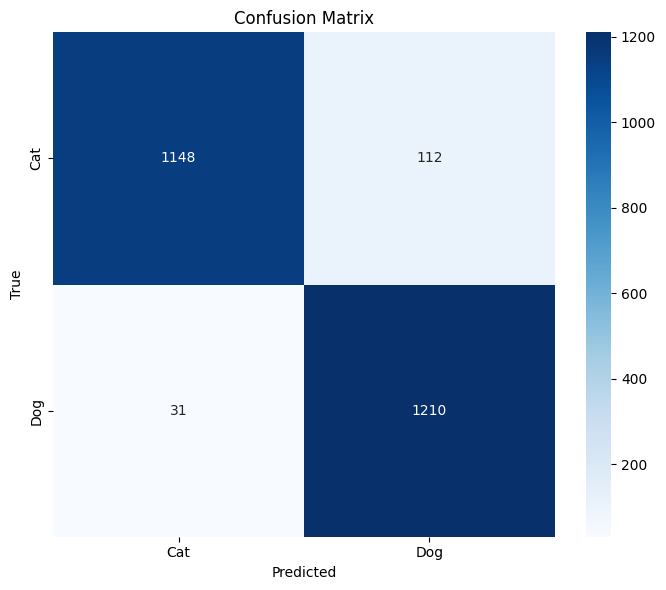

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("/kaggle/working/CNN_model/best_model.pth", map_location="cpu", weights_only=False)
model.to(device)

class_names = train_ds.dataset.classes

results = evaluate_model_binary(
    model,
    test_loader,
    device,
    class_names,
    save_dir="/kaggle/working/CNN_model/CNN_test_results"
)

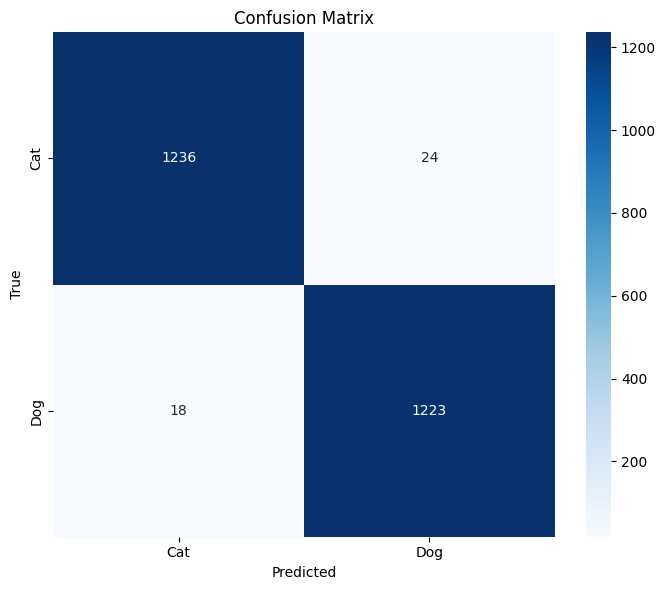

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("/kaggle/working/resnet_model/resnet_best_model.pth", map_location="cpu", weights_only=False)
model.to(device)

class_names = train_ds.dataset.classes

results = evaluate_model_binary(
    model,
    test_loader,
    device,
    class_names,
    save_dir="/kaggle/working/resnet_model/resnet_test_results"
)